# 3D sz's MODEL

- configuration A: (128 x 128 x 64 nodes) 128 CPUS
- configuration B: (256 x 256 x 96 nodes) 256 CPUS
The user should remove visualisation from the python script before running the model on raijin.
In [2]:


In [1]:
import matplotlib.pyplot as plt
import UWGeodynamics as GEO
u = GEO.UnitRegistry # u. +tab to see available units or u = GEO.u
import glucifer

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
##### Characteristic values of the system

half_rate = 1.8 * u.centimeter / u.year # What is it?
model_length = 4000e3 * u.meter
model_width = 2000e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 3570 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2 # ckeck publi schellart

KL = model_length # Characteristic length
Kt = KL / half_rate # Characteristic time 
KM = bodyforce * KL**2 * Kt**2 # Characteristic mass
KT = (baseModelTemp - surfaceTemp) # Characteristic temperature

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT


In [3]:
Model = GEO.Model(elementRes=(34, 34, 12), 
                  minCoord=(0. * u.kilometer, -0. * u.kilometer, -660. * u.kilometer), 
                  maxCoord=(4000. * u.kilometer, 2000. * u.kilometer, 20. * u.kilometer), 
                  gravity=(0.0 ,0.0, -9.81 * u.meter / u.second**2))

## Output

In [4]:
Model.outputDir="3D_sz_oblique_16_07_2018"

## Define Materials
The model has initially 4 materials (air, crust, mantle lithosphere and mantle). We add a fifth material for the sediment. Sediment will only appear if surface processes are turned on...(and if there is sedimentation of course)

In [6]:
## Definition of materials

air               = Model.add_material(name="Air", shape=GEO.shapes.Layer3D(top=Model.top, bottom=2.0 * u.kilometer))
stickyAir         = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer3D(top=air.bottom, bottom= 0.0 * u.kilometer)) # or water
#basalticrust        = Model.add_material(name="basalticrust", shape=GEO.shapes.Layer3D(top=stickyAir.bottom, bottom=-40.0 * u.kilometer))
weakZone          = Model.add_material(name="b_wz", shape=GEO.shapes.Layer3D(top=0.0, bottom=-120.0 * u.kilometer))
asthenosphere = Model.add_material(name="asthenosphere", shape=GEO.shapes.Layer3D(top=-120.0 * u.kilometer, bottom=Model.bottom))

wz_slope = GEO.shapes.HalfSpace(normal=(0.4,-0.2,-1.0), origin=(1995.*u.kilometer,1000.*u.kilometer, -127.*u.kilometer))
compositeShape = GEO.shapes.Layer3D(top=0., bottom=-120.0 * u.kilometer) & wz_slope
lithosphere = Model.add_material(name="lithosphere", shape=compositeShape)

## Definition of slab shape with 1 two shapes

# Plate part
top = GEO.shapes.HalfSpace(normal=(0.,0.,1.), origin=(2000.*u.kilometer,1000.*u.kilometer,-0.*u.kilometer))
right = GEO.shapes.HalfSpace(normal=(1.,0.,0.), origin=(4000.*u.kilometer,1000.*u.kilometer,-0.*u.kilometer))
bottom = GEO.shapes.HalfSpace(normal=(0.,0.,-1.), origin=(2000.*u.kilometer,1000.*u.kilometer,-120.*u.kilometer))
left = GEO.shapes.HalfSpace(normal=(-1.,0.5,0.), origin=(2422.*u.kilometer,1180.*u.kilometer,-320.*u.kilometer))

CompositeShape_plate = top & left & right & bottom
#Plate_lithosphere = Model.add_material(name="Slab_lithosphere", shape=CompositeShape_plate)


# Slab part
slableft = GEO.shapes.HalfSpace(normal=(-1.,0.5,0.), origin=(2067.*u.kilometer,1000.*u.kilometer,-320.*u.kilometer))
slabright = GEO.shapes.HalfSpace(normal=(1.,-0.5,0.), origin=(2422.*u.kilometer,1180.*u.kilometer,-320.*u.kilometer))
slopetop = GEO.shapes.HalfSpace(normal=(-0.4,0.2,1.), origin=(2005.*u.kilometer,1000.*u.kilometer,-127.*u.kilometer))
slopebottom = GEO.shapes.HalfSpace(normal=(0.4,-0.2,-1.), origin=(1975.*u.kilometer,1013.*u.kilometer,-257.*u.kilometer))

CompositeShape_slab = slableft & slopetop & slabright & slopebottom
#Slab_lithosphere = Model.add_material(name="Slab_lithosphere", shape=CompositeShape_slab)

# Forme finale
CompositeShape_final = GEO.shapes.MultiShape([CompositeShape_slab & CompositeShape_plate])
Slab_lithosphere = Model.add_material(name="litho", shape=CompositeShape_final)




Fig = glucifer.Figure()
Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)
#Fig.Mesh(Model.mesh)
viewer = Fig.viewer(resolution=(1200,600))
viewer = Fig.viewer(axis=True)
viewer.window()



AttributeError: 'Shape' object has no attribute 'top'

In [11]:
import numpy as np
np.unique(Model.materialField.data)

array([ 8,  9, 10, 11, 12, 13], dtype=int32)


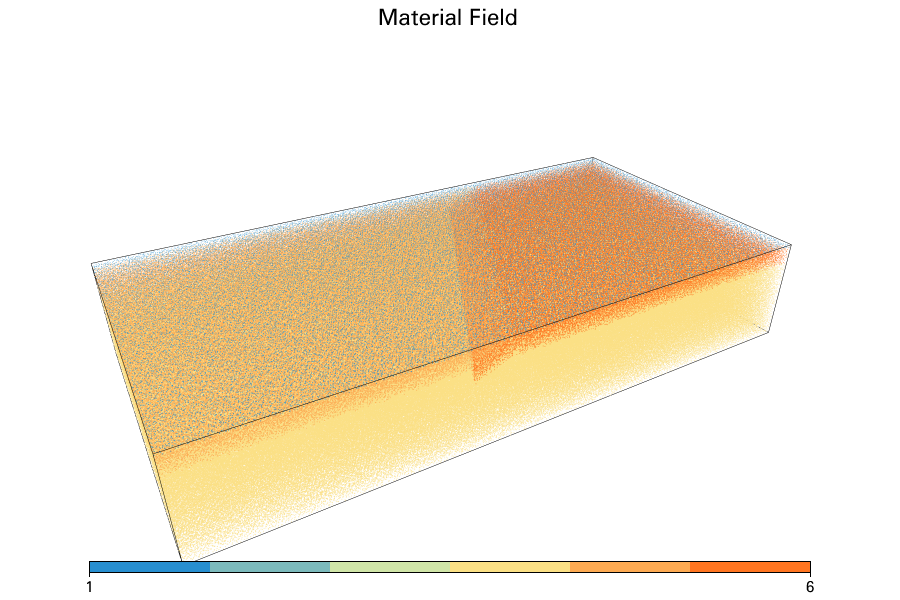

In [6]:
Fig = Model.plot.materialField(script=["rotate z 30", "rotate x -60"], figsize=(900,600))

## Limiters


In [ ]:
Model.stressLimiter = 300.0 * u.megapascal
Model.maxViscosity = 5.0e23 * u.pascal * u.second
Model.minViscosity = 1.0e19 * u.pascal * u.second
Model.diffusivity = 1.0e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

### Material specific definitions


In [ ]:
# Diffusivity

air.diffusivity = 1.0e-6 * u.metre**2 / u.second
stickyAir.diffusivity = 1.0e-6 * u.metre**2 / u.second
weakZone.diffusivity   = 1.1e-6 * u.metre**2 / u.second
lithosphere.diffusivity = 1.1e-6 * u.metre**2 / u.second
Slab_lithosphere.diffusivity = 1.1e-6 * u.metre**2 / u.second
asthenosphere.diffusivity = 1.1e-6 * u.metre**2 / u.second

Model.diffusivity = 1.0e-6 * u.metre**2 / u.second 


# capacity
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

In [ ]:
# Density

air.density               = 1. * u.kilogram / u.metre**3
stickyAir.density         = 1. * u.kilogram / u.metre**3
weakZone.density        = GEO.LinearDensity(2000. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
lithosphere.density = GEO.LinearDensity(3300. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
Slab_lithosphere.density = GEO.LinearDensity(3300. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
asthenosphere.density     = GEO.LinearDensity(3395. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)


In [ ]:
# Radiogenic Heat Production


weakZone.radiogenicHeatProd = 0.25 * u.microwatt / u.meter**3 # faccenda 2008: 1-5
lithosphere.radiogenicHeatProd = 0.022 * u.microwatt / u.meter**3 # faccenda 2008: 0.022
Slab_lithosphere.radiogenicHeatProd = 0.022 * u.microwatt / u.meter**3 # faccenda 2008: 0.022
asthenosphere.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3


### Viscous Rheologies

In [ ]:
rh = GEO.ViscousCreepRegistry() 

viscosity = GEO.ViscousCreep()
viscosity.activationEnergy = 200. * u.kilojoule

air.viscosity                = 1e18 * u.pascal * u.second
stickyAir.viscosity          = 1e19 * u.pascal * u.second # or water

weakZone.viscosity    = 1.0 * rh.Goetze_et_al_1978
weakZone.minViscosity = 1e18 * u.pascal * u.second
weakZone.maxViscosity = 5e23 * u.pascal * u.second


lithosphere.viscosity    = 1.0 * rh.Brace_and_Kohlstedt_1980 # 5.0 * rh.Karato_and_Wu_1990
lithosphere.minViscosity = 1e18 * u.pascal * u.second
lithosphere.maxViscosity = 5e23 * u.pascal * u.second

Slab_lithosphere.viscosity    = 1.0 * rh.Brace_and_Kohlstedt_1980 # 5.0 * rh.Karato_and_Wu_1990
Slab_lithosphere.minViscosity = 1e18 * u.pascal * u.second
Slab_lithosphere.maxViscosity = 5e23 * u.pascal * u.second

asthenosphere.viscosity    = rh.Brace_and_Kohlstedt_1980 
asthenosphere.minViscosity = 1e18 * u.pascal * u.second
asthenosphere.maxViscosity = 5e23 * u.pascal * u.second

minimumviscosity   = GEO.ConstantViscosity(1e18 * u.pascal * u.second)
maximumviscosity   = GEO.ConstantViscosity(5e23 * u.pascal * u.second)



## Plasticities

In [ ]:
pl = GEO.PlasticityRegistry()

In [ ]:

weakZone.plasticity     = pl.Rey_et_al_2010_Mantle
weakZone.stressLimiter  = 300 * u.megapascal

lithosphere.plasticity     = pl.Rey_et_al_2010_Mantle
lithosphere.stressLimiter  = 300 * u.megapascal

Slab_lithosphere.plasticity     = pl.Rey_et_al_2010_Mantle
Slab_lithosphere.stressLimiter  = 300 * u.megapascal

asthenosphere.plasticity     = pl.Rey_et_al_2010_Mantle
asthenosphere.stressLimiter  = 380 * u.megapascal # Rey and Muller 2010



In [ ]:
#basalticrust.plasticity

## Add Temperature Boundary Conditions

Temperature is 293.15K at the top and 3570K at the bottom. Temperature is constant in the mantle and the air layers. 

In [ ]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         indexSets=[(stickyAir.indices, 293.15 * u.degK ),
                                    (air.indices, 293.15 * u.degK )]) 


## Add Velocity Boundary Conditions

We push on the right side. The back and front wall are freeslip. We use a pseudo isostatic support condition at the bottom.

In [ ]:
Model.set_velocityBCs(left=[0., None, None],
                      right=[0., None, None],
                      back=[None, 0., None],
                      front=[None, 0., None],
                      bottom=[None, None, 0.],
                      top=[None, None, 0.])

# Add Passive Tracers 

In [ ]:
#help(Model.add_passive_tracers)

In [ ]:
import numpy as np

xp = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), 100)
yp = np.linspace(GEO.nd(Model.minCoord[1]), GEO.nd(Model.maxCoord[1]), 100)

xp, yp = np.meshgrid(xp, yp)
xp = xp.flatten()
yp = yp.flatten()
zp = np.zeros(xp.shape)

surface_tracers = Model.add_passive_tracers(name="Surface2", vertices=[xp, yp, zp])
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[xp, yp, zp+GEO.nd(asthenosphere.top)])


# Surface Processes / BADLANDS

In [ ]:
# Model.surfaceProcesses = GEO.surfaceProcesses.Badlands(airIndex=[air.index], sedimentIndex=sediment.index,
#                                            XML="ressources/badlands.xml", resolution=1. * u.kilometer, 
#                                            checkpoint_interval=0.01 * u.megayears)


#Model.surfaceProcesses = GEO.surfaceProcesses.SedimentationThreshold(Model.swarm, Model.materialField, air=[air, stickyAir], sediment=[sediment], threshold=0.)

In [ ]:
GEO.rcParams["initial.nonlinear.tolerance"]=0.02
GEO.rcParams["nonlinear.tolerance"]=0.02
GEO.rcParams["popcontrol.particles.per.cell.3D"]=60

In [ ]:
GEO.rcParams["solver"] = "mg" # This is the default so that line is technically not needed.

In [ ]:
Model.init_model()

In [ ]:
#Fig = Model.plot.temperature(script=["rotate z 30", "rotate x -60"], figsize=(900,600))

In [ ]:
#Fig = Model.plot.pressureField(script=["rotate z 30", "rotate x -60"], figsize=(900,600))

In [ ]:
#mohoT = Model.temperature.evaluate(moho_tracers.swarm)[:,0].mean() # attention pb parallelisation: Model.temperature.evaluate
#print("Moho Temperature = ", GEO.Dimensionalize(mohoT, u.degC)) 

#mohoT = Model.temperature.evaluate_global()

In [ ]:
Model.run_for( 20* u.millionyear, checkpoint_interval=1 * u.megayear)
